* Shreya Chetan Pawaskar

* 12041645

* pawaskas@uci.edu

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/mnist_data')

In [3]:
#import mltools as ml
import warnings
warnings.filterwarnings ("ignore")

In [4]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
#define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,
                               transform=transforms)

Text(10, -2, 'The label is 5')

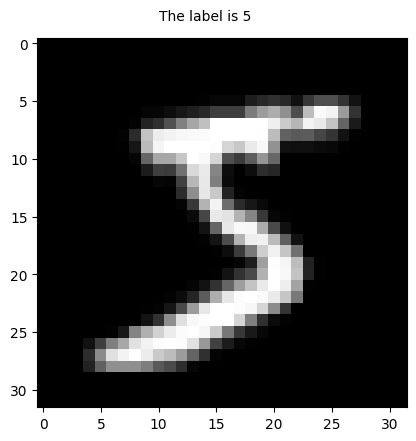

In [6]:
plt.imshow(train_dataset[0][0][0], cmap='gray')
plt.text(10, -2, 'The label is ' + str(train_dataset[0][1]))

In [7]:
# hyper parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

## 1.1.2

In [8]:
# define the data loaders
train_loader = DataLoader(dataset= train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle= True)

valid_loader = DataLoader(dataset= valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle= False)

## 1.1.3

In [9]:
def train(train_loader, model, criterion, optimizer):
    model.train()

    # Initialize the running loss for this epoch
    running_loss = 0

    # Iterate through batches in the training loader
    for X, y_true in train_loader:
        # Zero the gradients to avoid accumulation
        optimizer.zero_grad()

        # Forward pass
        y_hat, _ = model(X)  # Assuming the model returns predictions and other outputs if any
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate the average loss for the entire epoch
    epoch_loss = running_loss / len(train_loader.dataset)

    # Return the updated model, optimizer, and the epoch loss
    return model, optimizer, epoch_loss

## 1.1.4

In [10]:
def validate(valid_loader, model, criterion):
    # Set the model to evaluation mode
    model.eval()

    # Initialize the running loss for validation
    running_loss = 0

    # Iterate through batches in the validation loader
    for X, y_true in valid_loader:

        # Forward pass and record the loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)

        running_loss += loss.item() * X.size(0)

    # Calculate the average loss on the validation set
    epoch_loss = running_loss / len(valid_loader.dataset)

    # Return the model and the epoch loss on the validation set
    return model, epoch_loss

In [11]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, print_every=1):
    # Set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(0, epochs):

        # Training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer)
        train_losses.append(train_loss)

        # Validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion)
            valid_losses.append(valid_loss)

        # Print progress
        if epoch % print_every == (print_every - 1):

            # Calculate and append accuracy metrics
            train_acc = get_accuracy(model, train_loader,)
            train_accs.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader)
            valid_accs.append(valid_acc)

            print(f'{datetime.now().time().replace(microsecond=0)} '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')


    # Store performance metrics in a dictionary
    performance = {
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'train_acc': train_accs,
        'valid_acc': valid_accs
    }

    return model, optimizer, performance

## 1.1.5

In [12]:
def get_accuracy(model, data_loader):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''

    correct_pred = 0
    n = 0

    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            y_hat, _ = model(X)
            running_loss = criterion(y_hat, y_true)

            running_loss += running_loss.item() * X.size(0)
            _ , predicted_labels = torch.max(y_hat, 1)
            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [13]:
def plot_performance(performance):
    '''
    Function for plotting training and validation losses
    '''

    # temporarily change the style of the plots to seaborn
    plt.style.use('seaborn')

    fig, ax = plt.subplots(1, 2, figsize = (16, 4.5))
    for key, value in performance.items():
        if 'loss' in key:
            ax[0].plot(value, label=key)
        else:
            ax[1].plot(value, label=key)
    ax[0].set(title="Loss  over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax[1].set(title="accuracy over epochs",
            xlabel='Epoch',
            ylabel='Loss')
    ax[0].legend()
    ax[1].legend()
    plt.show()

    # change the plot style to default
    plt.style.use('default')

## 1.2.1

In [14]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        self.layers = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,stride=1),
            nn.Tanh()
        )

        self.model = nn.Sequential(
            nn. Linear(in_features=120, out_features=84),
            nn. Tanh(),
            nn. Linear(in_features=84, out_features=n_classes)
        )



    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, 1)
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## 1.2.2

In [15]:
class MLP(nn.Module):

    def __init__(self, layers):
        super(MLP, self).__init__()
        mlpLayers = []
        for i in range (len (layers) -2):
          mlpLayers.append(nn.Linear(layers[i],layers[i+1]))
          mlpLayers.append (nn.Tanh())

        mlpLayers.append(nn.Linear(layers[-2], layers [-1]))
        mlpLayers = tuple (mlpLayers)
        self.model = nn.Sequential(*mlpLayers)

    def forward(self, x):
        x = torch.flatten(x,1)
        logits = self.model(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## **1.3.1**

In [16]:
# Set the random seed for reproducibility
torch.manual_seed(RANDOM_SEED)

# Initialize the LeNet5 model with the specified number of classes
model = LeNet5(N_CLASSES)

# Initialize the Adam optimizer with the model parameters and the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define the CrossEntropyLoss criterion for training the model
criterion = nn.CrossEntropyLoss()

19:51:37 Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
19:52:50 Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
19:54:04 Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
19:55:20 Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
19:56:31 Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.25	Valid accuracy: 98.75
19:57:41 Epoch: 5	Train loss: 0.0299	Valid loss: 0.0422	Train accuracy: 99.41	Valid accuracy: 98.66
19:58:50 Epoch: 6	Train loss: 0.0241	Valid loss: 0.0409	Train accuracy: 99.47	Valid accuracy: 98.70
20:00:00 Epoch: 7	Train loss: 0.0228	Valid loss: 0.0418	Train accuracy: 99.57	Valid accuracy: 98.69
20:01:09 Epoch: 8	Train loss: 0.0186	Valid loss: 0.0447	Train accuracy: 99.53	Valid accuracy: 98.70
20:02:22 Epoch: 9	Train loss: 0.0161	Valid loss: 0.0468	Train accuracy: 99.64	Valid accuracy: 98.70


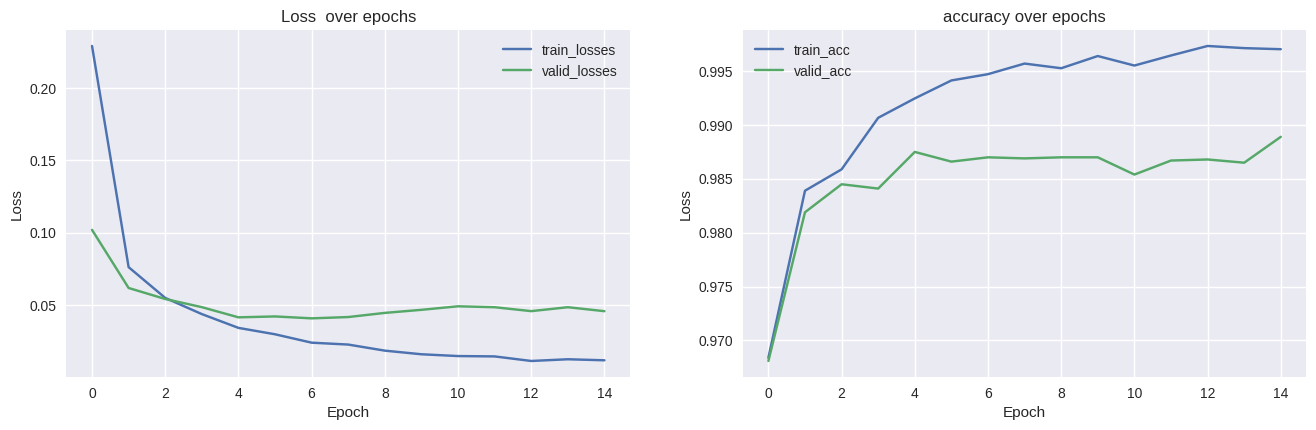

In [17]:
model, optimizer, performance_1 = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)
plot_performance(performance_1)

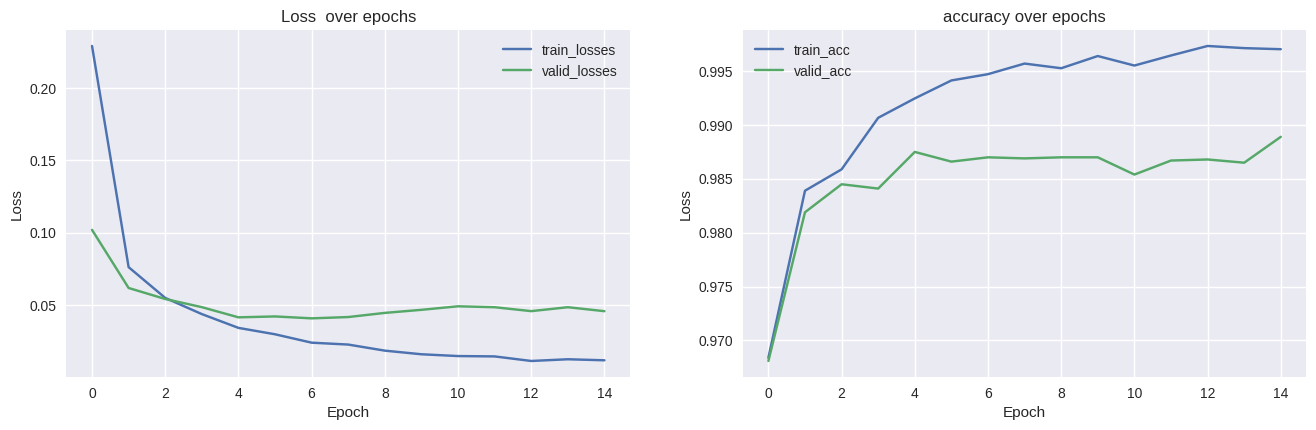

In [18]:
plot_performance(performance_1)

### 1.3.2

Using MLP

In [19]:
torch.manual_seed(RANDOM_SEED)
layers = [1024, 256, 64, 16, N_CLASSES]
model = MLP(layers)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

MLP(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [20]:
model, optimizer, performance_2 = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS)

20:08:56 Epoch: 0	Train loss: 0.3575	Valid loss: 0.1636	Train accuracy: 95.61	Valid accuracy: 95.23
20:09:40 Epoch: 1	Train loss: 0.1307	Valid loss: 0.1195	Train accuracy: 97.27	Valid accuracy: 96.38
20:10:24 Epoch: 2	Train loss: 0.0927	Valid loss: 0.1016	Train accuracy: 97.93	Valid accuracy: 96.97
20:11:08 Epoch: 3	Train loss: 0.0725	Valid loss: 0.0896	Train accuracy: 98.21	Valid accuracy: 97.26
20:11:52 Epoch: 4	Train loss: 0.0592	Valid loss: 0.0844	Train accuracy: 98.41	Valid accuracy: 97.45
20:12:37 Epoch: 5	Train loss: 0.0514	Valid loss: 0.0973	Train accuracy: 98.33	Valid accuracy: 97.14
20:13:20 Epoch: 6	Train loss: 0.0433	Valid loss: 0.0845	Train accuracy: 98.80	Valid accuracy: 97.35
20:14:04 Epoch: 7	Train loss: 0.0380	Valid loss: 0.0728	Train accuracy: 99.25	Valid accuracy: 97.79
20:14:48 Epoch: 8	Train loss: 0.0328	Valid loss: 0.0822	Train accuracy: 99.25	Valid accuracy: 97.76
20:15:31 Epoch: 9	Train loss: 0.0324	Valid loss: 0.0801	Train accuracy: 99.42	Valid accuracy: 97.82


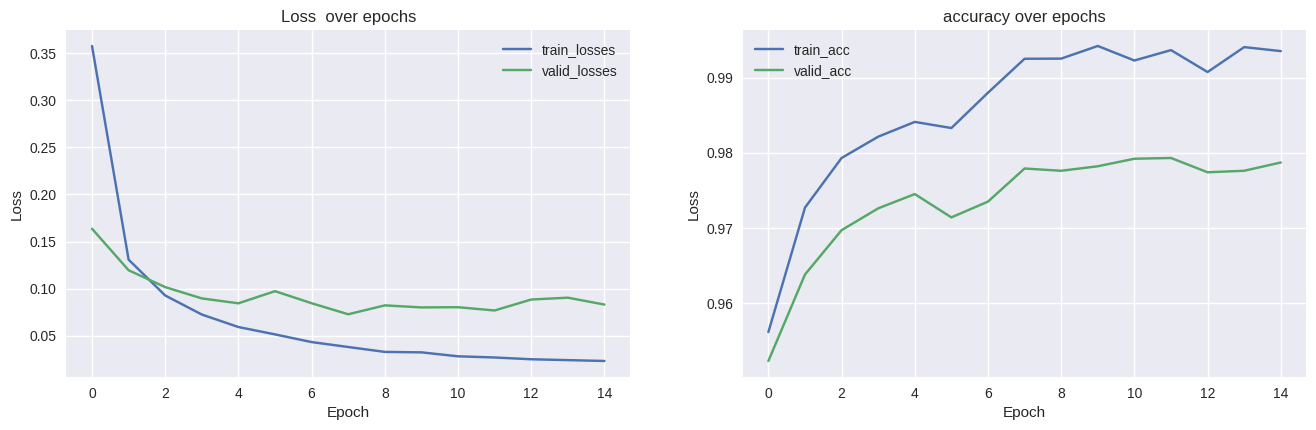

In [21]:
plot_performance(performance_2)

### 1.4.1

*What is the number of trainable parameters of LeNet?*

* Trainable Parameters = weight + bias.
* convi1 = (150 + 6) = 156
* convI3 = (2400 + 16) = 2416
* conv6 = (48000 + 120) = 48120
* classifier1 = (120*84) + 84 = (10080 + 84) = 10164
* classifier2 = (84 * 10) +10 =(840 + 10) = 850
* Total (LeNet5 params): **61706.**

### 1.4.2

*What is the number of trainable parameters of MLP?*

* Trainable Parameters = weight + bias
* classifierl1 = (1024 * 256)+256 =(262144 + 256) = 262400
* classifierl2 = (256 * 64) + 64 =(16384 +64) = 16448
* classiferI3 = (64 * 16) + 16 = (1024 +16) = 1040
* classifierI4 = (16 * 10) + 10 = (160 +10) = 170
* Total (MLP params): **280058**



### **1.4.3**

Which model has better performance in terms of prediction accuracy on the test data?

* LeNet5 uses the convolutional layers as feature extractor, these help in better prediction of classes and hence better accuracy.
* CNNs can grasp how pixels relate spatially in images, unlike MLPs that lose this by turning images into flat vectors.
* CNNs excel at understanding visual patterns due to their specialized architecture.
* So, **LeNet5** performs better than MLP in terms of prediction accuracy on the test data.

### ***Statement of Collboration***

I did the homework on my own with help of some online documentation on the pytorch model architecture.